##**Quality Inspection for Casting product**
####Dataset Link: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product/versions/1

####**Setting up data directory**
1. Go to Kaggle Settings
2. Generate API token
3. Upload the downloaded JSON file to the working area

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Dataset URL: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 89% 89.0M/100M [00:01<00:00, 77.6MB/s]
100% 100M/100M [00:01<00:00, 68.7MB/s] 


In [4]:
!unzip /content/real-life-industrial-dataset-of-casting-product.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5282.jp

####**Installing the required libraries**

In [4]:
!pip3 install tensorflow numpy matplotlib keras

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
import imghdr
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


####**Reading the data**

In [6]:
def plot_images_from_directory(directory_path, class_front, num_images=4):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_front}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

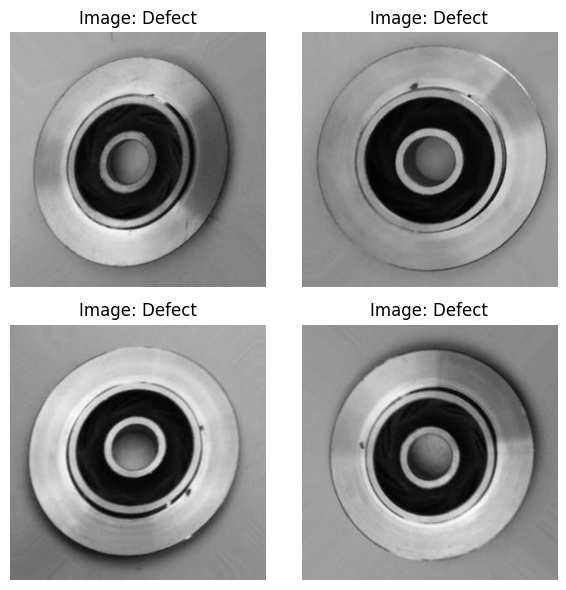

In [7]:
# Placeholder for the directory path
def_directory_path = '/content/casting_data/casting_data/train/def_front'  # Replace with your directory path
plot_images_from_directory(def_directory_path, class_front = 'Defect')

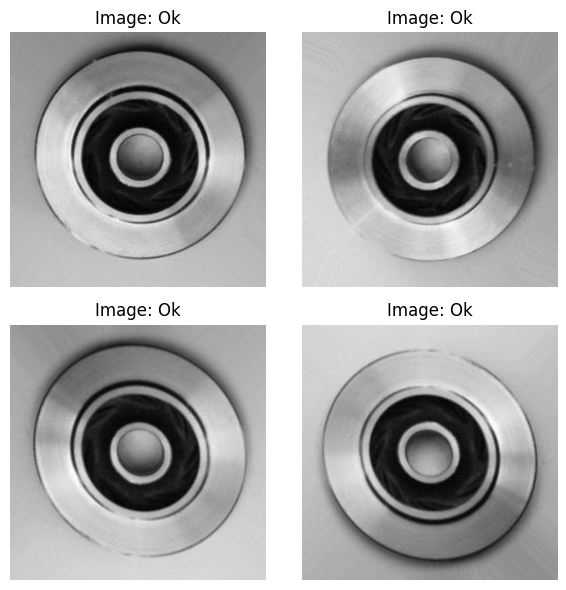

In [8]:
# Placeholder for the directory path
ok_directory_path = '/content/casting_data/casting_data/train/ok_front'  # Replace with your directory path
plot_images_from_directory(ok_directory_path, class_front = 'Ok')

In [9]:
def_images = os.listdir(def_directory_path)
ok_images = os.listdir(ok_directory_path)

classes_front = ['Defected', 'Ok']
count = [len(def_images), len(ok_images)]

print(count)

[3758, 2875]


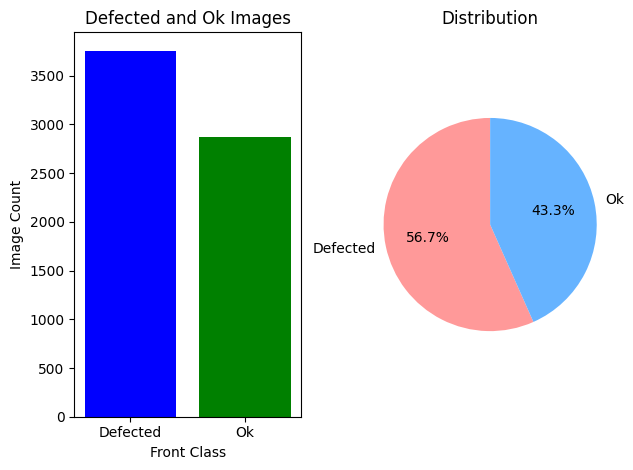

In [10]:
# Creating both a bar chart and a pie chart side by side in a single figure

# Setting up a figure and axes for two subplots: one for the bar chart, one for the pie chart
fig, ax = plt.subplots(1, 2)

# Bar chart on the first subplot
ax[0].bar(classes_front, count, color=['blue', 'green'])
ax[0].set_xlabel('Front Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Defected and Ok Images')

# Pie chart on the second subplot
colors = ['#ff9999','#66b3ff']
ax[1].pie(count, labels=classes_front, colors=colors, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Distribution')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the layout so that both subplots fit nicely
plt.tight_layout()
plt.show()


####**Removing Corrupted Images**

In [11]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/casting_data/casting_data'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

####**Loading Shapes and Channels**

In [29]:
def image_to_array(image_path):
    """
    Read an image and convert it to a numpy array.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    np.array: The image as a numpy array.
    """
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

array([[[159, 159, 159],
        [159, 159, 159],
        [159, 159, 159],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]],

       [[158, 158, 158],
        [159, 159, 159],
        [159, 159, 159],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]],

       [[158, 158, 158],
        [158, 158, 158],
        [158, 158, 158],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]],

       ...,

       [[156, 156, 156],
        [156, 156, 156],
        [156, 156, 156],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]],

       [[157, 157, 157],
        [157, 157, 157],
        [157, 157, 157],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]],

       [[158, 158, 158],
        [158, 158, 158],
        [158, 158, 158],
        ...,
        [135, 135, 135],
        [135, 135, 135],
        [135, 135, 135]]], dtype=uint8)
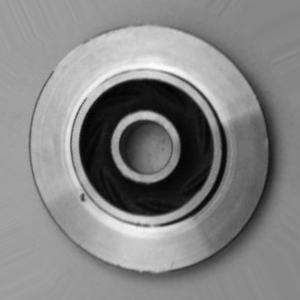

In [30]:
image_to_array('/content/casting_data/casting_data/train/def_front/cast_def_0_0.jpeg')

In [14]:
#As the images are grayscale
def image_to_array(image_path):
    """
    Read an image and convert it to a numpy array.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    np.array: The image as a numpy array.
    """
    try:
      img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      #img_pil = Image.open(image_path)
      #img_array = np.array(img_pil)
      #print(img_array)
      print("Pixel Array:",img)
      print("Shape:", img.shape)
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

In [15]:
image_to_array('/content/casting_data/casting_data/train/def_front/cast_def_0_0.jpeg')

Pixel Array: [[159 159 159 ... 135 135 135]
 [158 159 159 ... 135 135 135]
 [158 158 158 ... 135 135 135]
 ...
 [156 156 156 ... 135 135 135]
 [157 157 157 ... 135 135 135]
 [158 158 158 ... 135 135 135]]
Shape: (300, 300)


In [16]:
!pip3 install opencv-python

####**Building Model**

In [40]:
# Set path to the dataset
base_dir = '/content/casting_data/casting_data/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [41]:
 # Using 20% of data for validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(300, 300),
    batch_size=20,
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    #color_mode='grayscale',
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(300, 300),
    batch_size=20,
    class_mode='binary',
    #color_mode='grayscale',
    subset='validation')  # Set as validation data

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


####**Getting Class Labels**

In [42]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

Training class labels: {'def_front': 0, 'ok_front': 1}
Validation class labels: {'def_front': 0, 'ok_front': 1}


####**Visualizing batch images**

In [43]:
# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(10,10))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


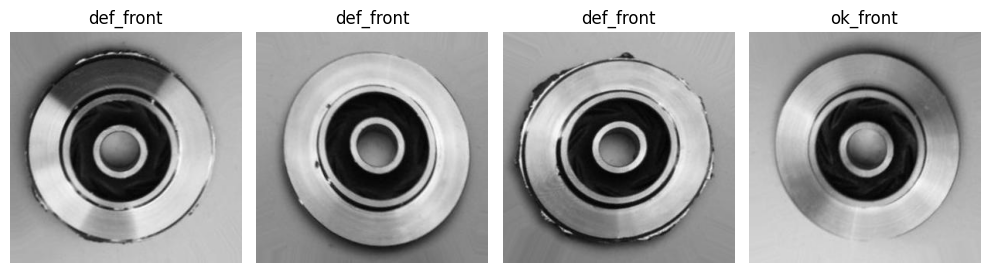

In [44]:
# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [45]:
train_generator.reset()

####**CNN Model**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [49]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 35, 35, 128)      

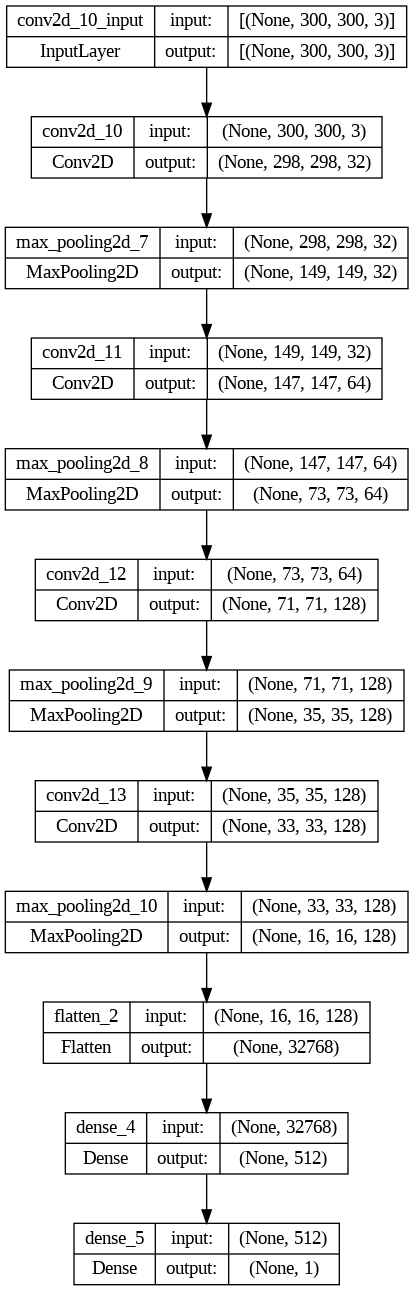

In [50]:
plot_model(model, to_file = 'Architecture.png',
           show_shapes=True, show_layer_names=True)

In [51]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [52]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

266.0 67.0


In [53]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=266,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=67)

Epoch 1/10
266/266 [==============================] - 27s 82ms/step - loss: 0.6293 - accuracy: 0.6431 - val_loss: 0.2941 - val_accuracy: 0.9035
Epoch 2/10
266/266 [==============================] - 21s 78ms/step - loss: 0.2126 - accuracy: 0.9114 - val_loss: 0.2554 - val_accuracy: 0.9095
Epoch 3/10
266/266 [==============================] - 20s 75ms/step - loss: 0.1075 - accuracy: 0.9612 - val_loss: 0.1144 - val_accuracy: 0.9502
Epoch 4/10
266/266 [==============================] - 20s 75ms/step - loss: 0.0667 - accuracy: 0.9764 - val_loss: 0.0501 - val_accuracy: 0.9827
Epoch 5/10
266/266 [==============================] - 20s 74ms/step - loss: 0.0467 - accuracy: 0.9845 - val_loss: 0.0380 - val_accuracy: 0.9864
Epoch 6/10
266/266 [==============================] - 20s 75ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0422 - val_accuracy: 0.9864
Epoch 7/10
266/266 [==============================] - 20s 76ms/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.0394 - val_accuracy:

In [54]:
history.history

{'loss': [0.6293240785598755,
  0.2125852257013321,
  0.1074533611536026,
  0.06667648255825043,
  0.046656493097543716,
  0.03628690168261528,
  0.03526981547474861,
  0.017802517861127853,
  0.04239610955119133,
  0.026621276512742043],
 'accuracy': [0.6431128978729248,
  0.9114377498626709,
  0.9611833691596985,
  0.9764462113380432,
  0.9845486879348755,
  0.9886941909790039,
  0.9892594814300537,
  0.9954776763916016,
  0.9845486879348755,
  0.9913321733474731],
 'val_loss': [0.29411354660987854,
  0.25540125370025635,
  0.11439140141010284,
  0.05012398213148117,
  0.037969015538692474,
  0.04215293005108833,
  0.039395060390233994,
  0.056528590619564056,
  0.03455265611410141,
  0.029054472222924232],
 'val_accuracy': [0.9034690856933594,
  0.9095022678375244,
  0.9502262473106384,
  0.9826545715332031,
  0.9864253401756287,
  0.9864253401756287,
  0.9849170446395874,
  0.9819004535675049,
  0.9879336357116699,
  0.9932126402854919]}

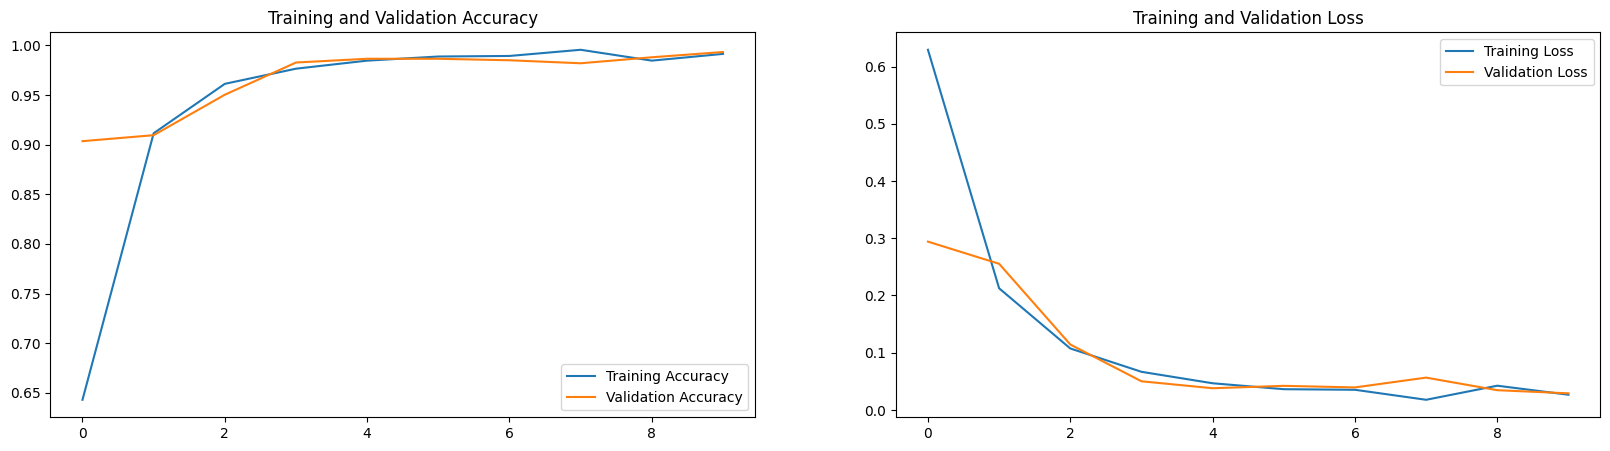

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####**Model Evaluation**

In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

test_dir = '/content/casting_data/casting_data/test'  # Path to your test directory

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),  # Should match the input size of your network
    batch_size=20,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=False)  # No need to shuffle test data

Found 715 images belonging to 2 classes.


####**Making Test Predictions**

In [57]:
np.ceil(test_generator.samples/test_generator.batch_size)

36.0

In [58]:
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))
probabilities

36/36 [==============================] - 3s 72ms/step


array([[8.23163120e-08],
       [8.51163077e-06],
       [1.89189870e-15],
       [2.16378684e-08],
       [4.52658838e-21],
       [3.85579071e-28],
       [3.23238760e-06],
       [1.12219805e-05],
       [2.18789478e-15],
       [6.39469874e-07],
       [3.27838020e-26],
       [7.60672504e-13],
       [1.31246294e-12],
       [6.44613749e-07],
       [1.76150171e-21],
       [6.95951144e-11],
       [3.59507358e-05],
       [1.89182587e-23],
       [2.33085865e-16],
       [3.28610542e-11],
       [3.97176336e-06],
       [1.65940244e-24],
       [5.26397234e-05],
       [2.46339038e-08],
       [2.71124256e-28],
       [8.71328218e-11],
       [2.64470792e-08],
       [3.16274189e-08],
       [9.91467781e-18],
       [1.03672599e-08],
       [1.65664567e-08],
       [3.76446409e-11],
       [4.72981250e-03],
       [3.50663001e-08],
       [4.28816323e-11],
       [8.61327578e-08],
       [5.69882195e-18],
       [8.23902490e-04],
       [6.67267167e-25],
       [2.65942290e-08],


In [59]:
# Reset the test generator
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes

# Predict probabilities for the positive class
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

36/36 [==============================] - 3s 77ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

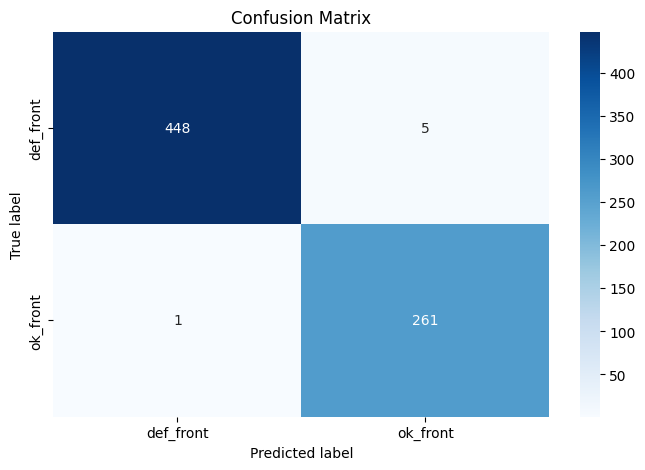

In [62]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [63]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

36/36 [==============================] - 2s 60ms/step - loss: 0.0176 - accuracy: 0.9916
Test accuracy: 99.16%
Test loss: 0.02


In [64]:
def make_prediction(image_path):
    img = load_img(image_path, target_size=(300, 300))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Ok')
    else:
        plt.title('Predicted: Defected')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 [==============================] - 1s 616ms/step
Prediction: [[7.0051835e-17]]


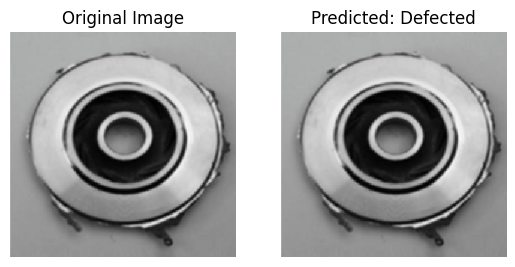

In [65]:
# Load and preprocess the image
img_path = '/content/def.png'
make_prediction(img_path)

####**Misclassifications**

In [66]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

36/36 [==============================] - 2s 57ms/step
Total misclassifications in the test set: 6 out of 715


36/36 [==============================] - 2s 48ms/step
Total misclassifications: 6


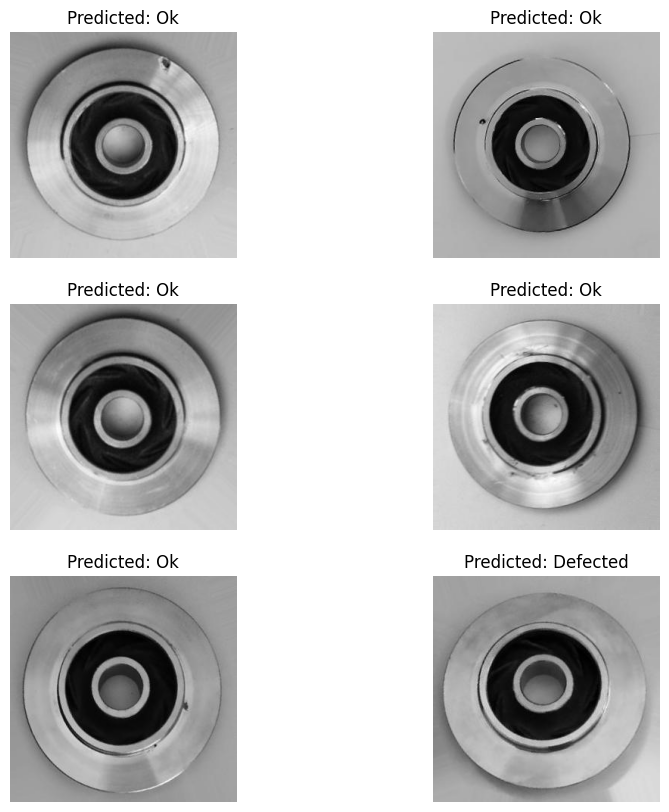

In [69]:
# Generate predictions for all test images
predictions = model.predict(test_generator)
# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

# Filenames can also be useful for debugging
filenames = test_generator.filenames
# Identifying indices of misclassified images
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 6
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(300, 300))

    # Predicted class
    predicted_class = "Ok" if predicted_classes[index] else "Defected"

    # Display
    plt.subplot(3, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()